Added the number of channels in Conv2d layers  
Added the number of nuerons in Linear layers

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageChops
import numpy as np
import pandas as pd
import torchvision
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)

In [ ]:
class CNN7(nn.Module):
    def __init__(self):
        super(CNN7,self).__init__()
        
        self.conv1=nn.Sequential(
            nn.Conv2d(
                in_channels=3,    #前面的层有多高
                out_channels=64,   #filter 的个数
                kernel_size=7,
                stride=1,
                padding=(3,3)  # if stride=1, padding=(kernel_size-1)/2
            ), 
            nn.ReLU(),   
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )
        
        self.conv2=nn.Sequential(
            nn.Conv2d(64,64,7,1,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )

        
        self.conv3=nn.Sequential(
            nn.Conv2d(64,128,7,1,3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        
        self.conv4=nn.Sequential(
            nn.Conv2d(128,256,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )
        
        self.conv5=nn.Sequential(
            nn.Conv2d(256,256,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )
        
        self.conv6=nn.Sequential(
            nn.Conv2d(256,256,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )
        
        self.conv7=nn.Sequential(
            nn.Conv2d(256,512,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2)
        )


        self.dense1=nn.Sequential(
            nn.Linear(2*2*512,2048),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        
        self.dense2=nn.Sequential(
            nn.Linear(2048,4096),
            nn.Dropout(0.5),
            nn.ReLU()
        )
        
        self.dense3=nn.Sequential(
            nn.Linear(4096,2048),
            nn.Dropout(0.5),
            nn.ReLU()
        )
       
        self.out=nn.Linear(2048,101)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.conv6(x)
        x=self.conv7(x)
        x=x.view(x.size(0),-1)
        x=self.dense1(x)
        x=self.dense2(x)
        x=self.dense3(x)
        output=self.out(x)
        return output       
cnn7=CNN7().cuda()
print(cnn7)

In [ ]:
EPOCH = 30
BATCH_SIZE=64
LR=0.001
optimizer=torch.optim.Adam(cnn7.parameters(),lr=LR,weight_decay=0.001)
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, 
    verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
loss_func=nn.CrossEntropyLoss()


In [ ]:
train_data = torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/train',transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((256,256)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
            torchvision.transforms.ToTensor()]))

eval_data=torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/eval',transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor()]))

test_data=torchvision.datasets.ImageFolder('/kaggle/input/caltech101/Caltech101/test',transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),torchvision.transforms.ToTensor()]))

train_loader=Data.DataLoader(dataset=train_data,batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=2)
eval_loader=Data.DataLoader(dataset=eval_data,batch_size=200,
                             shuffle=True, num_workers=2)
test_loader=Data.DataLoader(dataset=test_data,batch_size=200,
                             shuffle=True, num_workers=2)

In [ ]:
losses=[]
train_accs=[]
eval_accs=[]
for epoch in range(EPOCH):
    for step,(x,y) in enumerate(train_loader):
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()
        
        output=cnn7(b_x)   #change
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step%10==0:
            with torch.no_grad():
                pred_y=torch.max(output,1)[1].cuda().data.squeeze()
                train_accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
                train_accs.append(train_accuracy)
                losses.append(loss.data)
                torch.cuda.empty_cache()
                eval_acc=[]
                for x,y in eval_loader:
                    b_x=Variable(x).cuda()
                    b_y=Variable(y).cuda()        
                    output=cnn7(b_x)         #change
                    pred_y=torch.max(output,1)[1].cuda().data.squeeze()
                    accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
                    eval_acc.append(accuracy)
                eval_accs.append(np.mean(eval_acc))
                print('Epoch: ',epoch,'| Step: ',step,'| loss: ',loss.data,
                      '| Train_acc: ', train_accuracy,'| Eval_acc: ', np.mean(eval_acc))

 


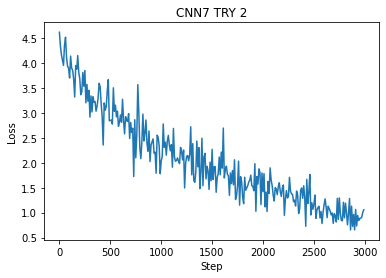

In [21]:
x=np.arange(len(losses))*10
plt.plot(x,losses)
plt.title('CNN7 TRY 2')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

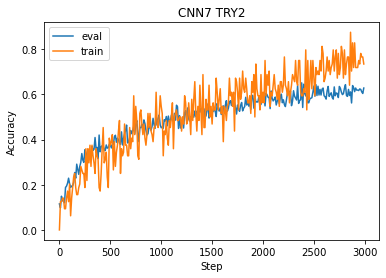

In [22]:
plt.plot(x,eval_accs,label='eval')
plt.plot(x,train_accs,label='train')
plt.title('CNN7 TRY2')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
torch.save(cnn7.state_dict(),'CNN7 try2')
#torch.save(cnn1,'CNN1_model.pkl')

In [24]:
train_acc=[]
with torch.no_grad():
    for x,y in train_loader:
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()        
        output=cnn7(b_x)
        pred_y=torch.max(output,1)[1].cuda().data.squeeze()
        accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
        train_acc.append(accuracy)
train_acc

[0.796875,
 0.75,
 0.84375,
 0.78125,
 0.8125,
 0.671875,
 0.75,
 0.796875,
 0.828125,
 0.796875,
 0.75,
 0.78125,
 0.78125,
 0.84375,
 0.828125,
 0.84375,
 0.6875,
 0.765625,
 0.78125,
 0.78125,
 0.8125,
 0.828125,
 0.84375,
 0.765625,
 0.859375,
 0.734375,
 0.75,
 0.796875,
 0.78125,
 0.75,
 0.875,
 0.828125,
 0.828125,
 0.6875,
 0.734375,
 0.765625,
 0.75,
 0.78125,
 0.71875,
 0.703125,
 0.84375,
 0.71875,
 0.75,
 0.703125,
 0.765625,
 0.765625,
 0.796875,
 0.75,
 0.71875,
 0.796875,
 0.796875,
 0.78125,
 0.765625,
 0.734375,
 0.796875,
 0.703125,
 0.734375,
 0.765625,
 0.828125,
 0.796875,
 0.78125,
 0.78125,
 0.890625,
 0.84375,
 0.859375,
 0.859375,
 0.84375,
 0.796875,
 0.8125,
 0.8125,
 0.734375,
 0.75,
 0.703125,
 0.765625,
 0.90625,
 0.734375,
 0.796875,
 0.78125,
 0.765625,
 0.765625,
 0.84375,
 0.75,
 0.765625,
 0.875,
 0.765625,
 0.765625,
 0.78125,
 0.8125,
 0.8125,
 0.828125,
 0.796875,
 0.765625,
 0.78125,
 0.828125,
 0.796875,
 0.796875,
 0.6111111111111112]

In [25]:
eval_acc=[]
with torch.no_grad():
    for x,y in eval_loader:
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()        
        output=cnn7(b_x)
        pred_y=torch.max(output,1)[1].cuda().data.squeeze()
        accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
        eval_acc.append(accuracy)
eval_acc

[0.605, 0.61, 0.58, 0.685, 0.9]

In [26]:
test_acc=[]
with torch.no_grad():
    for x,y in eval_loader:
        b_x=Variable(x).cuda()
        b_y=Variable(y).cuda()        
        output=cnn7(b_x)
        pred_y=torch.max(output,1)[1].cuda().data.squeeze()
        accuracy=sum(pred_y==b_y).cpu().numpy()/b_y.size(0)
        test_acc.append(accuracy)
test_acc

[0.63, 0.66, 0.625, 0.605, 0.65]

In [27]:
np.mean(train_acc)

0.78287872279496

In [28]:
np.mean(eval_acc)

0.6759999999999999

In [29]:
np.mean(test_acc)

0.634